<a href="https://colab.research.google.com/github/ShreshthSaxena/Algorithmic-Trading/blob/master/algo_trading_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

import pandas as pd
import numpy as np
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
from sklearn import preprocessing
import matplotlib.pyplot as plt
import math, time
import tensorflow as tf


Using TensorFlow backend.


In [3]:
from pandas_datareader import data as pdr
import fix_yahoo_finance

def get(tickers, startdate, enddate):
  def data(ticker):
    return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
  datas = map (data, tickers)
  return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))

tickers = ['AAPL', 'MSFT', 'IBM', 'GOOG']
all_data = get(tickers, datetime.datetime(2012, 10, 1), datetime.datetime(2018, 1, 1))

all_data.head()

High        Low       Open      Close       Volume  \
Ticker Date                                                                  
AAPL   2012-10-01  96.678574  93.785713  95.879997  94.198570  135898700.0   
       2012-10-02  95.192856  92.949997  94.544289  94.472855  156998100.0   
       2012-10-03  95.980003  94.661430  94.980003  95.921425  106070300.0   
       2012-10-04  96.321426  95.078575  95.892860  95.257141   92681400.0   
       2012-10-05  95.142860  93.040001  95.028572  93.227142  148501500.0   

                   Adj Close  
Ticker Date                   
AAPL   2012-10-01  64.749588  
       2012-10-02  64.938141  
       2012-10-03  65.933838  
       2012-10-04  65.477219  
       2012-10-05  64.081856

In [0]:
aapl = pdr.get_data_yahoo('AAPL', 
                          start=datetime.datetime(2000, 10, 1), 
                          end=datetime.datetime(2012, 1, 1))

In [5]:
df= aapl.drop(['Close'],1)
print(df.shape)
df.head()

(2830, 5)


,High,Low,Open,Volume,Adj Close
Date,,,,,
2000-10-02,1.910714,1.678571,1.906250,606197200.0,1.154998
2000-10-03,1.785714,1.584821,1.781250,509530000.0,1.062717
2000-10-04,1.696429,1.562500,1.598214,366506000.0,1.125230
2000-10-05,1.750000,1.571429,1.678571,218251600.0,1.050810
2000-10-06,1.638393,1.500000,1.620536,153164200.0,1.056764


In [6]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()

def normalize_data(df):
  smoothing_window_size = 500
  for di in range(0,2830,smoothing_window_size):
      if di +  smoothing_window_size > df.shape[0]:
        dil  = df.shape[0]
      else:
        dil = di+smoothing_window_size
      df['Open'][di:dil] = np.squeeze(scaler.fit_transform(df.Open.values.reshape(-1,1)[di:dil]))
      df['High'][di:dil] = np.squeeze(scaler.fit_transform(df.High.values.reshape(-1,1)[di:dil]))
      df['Low'][di:dil] = np.squeeze(scaler.fit_transform(df.Low.values.reshape(-1,1)[di:dil]))
      df['Volume'][di:dil] = np.squeeze(scaler.fit_transform(df.Volume.values.reshape(-1,1)[di:dil]))
      df['Adj Close'][di:dil] = np.squeeze(scaler.fit_transform(df['Adj Close'].values.reshape(-1,1)[di:dil]))
  return df
    
dfw = normalize_data(df)
dfw.tail()


,High,Low,Open,Volume,Adj Close
Date,,,,,
2011-12-23,0.854122,0.890344,0.858471,0.064929,0.878158
2011-12-27,0.888840,0.913803,0.880339,0.062420,0.898777
2011-12-28,0.883538,0.902638,0.904643,0.041292,0.873712
2011-12-29,0.867125,0.897122,0.882262,0.033933,0.889691
2011-12-30,0.871102,0.916927,0.882968,0.012862,0.888918


In [0]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) # 5
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]


In [8]:
window = 22
X_train, y_train, X_test, y_test = load_data(df, window)
X_train.shape

(2526, 22, 5)

In [0]:
def _time_distributed_dense(x, w, b=None, dropout=None,
                           input_dim=None, output_dim=None, timesteps=None):
    '''Apply y.w + b for every temporal slice y of x.
    '''
    if not input_dim:
        # won't work with TensorFlow
        input_dim = K.shape(x)[2]
    if not timesteps:
        # won't work with TensorFlow
        timesteps = K.shape(x)[1]
    if not output_dim:
        # won't work with TensorFlow
        output_dim = K.shape(w)[1]

    if dropout:
        # apply the same dropout pattern at every timestep
        ones = K.ones_like(K.reshape(x[:, 0, :], (-1, input_dim)))
        dropout_matrix = K.dropout(ones, dropout)
        expanded_dropout_matrix = K.repeat(dropout_matrix, timesteps)
        x *= expanded_dropout_matrix

    # collapse time dimension and batch dimension together
    x = K.reshape(x, (-1, input_dim))

    x = K.dot(x, w)
    if b:
        x = x + b
    # reshape to 3D tensor
    x = K.reshape(x, (-1, timesteps, output_dim))
    return x

In [0]:
import tensorflow as tf
from keras import backend as K
from keras import regularizers, constraints, initializers, activations
from keras.layers.recurrent import Recurrent
from keras.engine import InputSpec

tfPrint = lambda d, T: tf.Print(input_=T, data=[T, tf.shape(T)], message=d)

class AttentionDecoder(Recurrent):

    def __init__(self, units, output_dim,
                 activation='tanh',
                 return_probabilities=False,
                 name='AttentionDecoder',
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        """
        Implements an AttentionDecoder that takes in a sequence encoded by an
        encoder and outputs the decoded states
        :param units: dimension of the hidden state and the attention matrices
        :param output_dim: the number of labels in the output space

        references:
            Bahdanau, Dzmitry, Kyunghyun Cho, and Yoshua Bengio.
            "Neural machine translation by jointly learning to align and translate."
            arXiv preprint arXiv:1409.0473 (2014).
        """
        self.units = units
        self.output_dim = output_dim
        self.return_probabilities = return_probabilities
        self.activation = activations.get(activation)
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        super(AttentionDecoder, self).__init__(**kwargs)
        self.name = name
        self.return_sequences = True  # must return sequences

    def build(self, input_shape):
        """
          See Appendix 2 of Bahdanau 2014, arXiv:1409.0473
          for model details that correspond to the matrices here.
        """

        self.batch_size, self.timesteps, self.input_dim = input_shape

        if self.stateful:
            super(AttentionDecoder, self).reset_states()

        self.states = [None, None]  # y, s

        """
            Matrices for creating the context vector
        """

        self.V_a = self.add_weight(shape=(self.units,),
                                   name='V_a',
                                   initializer=self.kernel_initializer,
                                   regularizer=self.kernel_regularizer,
                                   constraint=self.kernel_constraint)
        self.W_a = self.add_weight(shape=(self.units, self.units),
                                   name='W_a',
                                   initializer=self.kernel_initializer,
                                   regularizer=self.kernel_regularizer,
                                   constraint=self.kernel_constraint)
        self.U_a = self.add_weight(shape=(self.input_dim, self.units),
                                   name='U_a',
                                   initializer=self.kernel_initializer,
                                   regularizer=self.kernel_regularizer,
                                   constraint=self.kernel_constraint)
        self.b_a = self.add_weight(shape=(self.units,),
                                   name='b_a',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        """
            Matrices for the r (reset) gate
        """
        self.C_r = self.add_weight(shape=(self.input_dim, self.units),
                                   name='C_r',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_r = self.add_weight(shape=(self.units, self.units),
                                   name='U_r',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_r = self.add_weight(shape=(self.output_dim, self.units),
                                   name='W_r',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_r = self.add_weight(shape=(self.units, ),
                                   name='b_r',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)

        """
            Matrices for the z (update) gate
        """
        self.C_z = self.add_weight(shape=(self.input_dim, self.units),
                                   name='C_z',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_z = self.add_weight(shape=(self.units, self.units),
                                   name='U_z',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_z = self.add_weight(shape=(self.output_dim, self.units),
                                   name='W_z',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_z = self.add_weight(shape=(self.units, ),
                                   name='b_z',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        """
            Matrices for the proposal
        """
        self.C_p = self.add_weight(shape=(self.input_dim, self.units),
                                   name='C_p',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_p = self.add_weight(shape=(self.units, self.units),
                                   name='U_p',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_p = self.add_weight(shape=(self.output_dim, self.units),
                                   name='W_p',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_p = self.add_weight(shape=(self.units, ),
                                   name='b_p',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        """
            Matrices for making the final prediction vector
        """
        self.C_o = self.add_weight(shape=(self.input_dim, self.output_dim),
                                   name='C_o',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_o = self.add_weight(shape=(self.units, self.output_dim),
                                   name='U_o',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_o = self.add_weight(shape=(self.output_dim, self.output_dim),
                                   name='W_o',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_o = self.add_weight(shape=(self.output_dim, ),
                                   name='b_o',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)

        # For creating the initial state:
        self.W_s = self.add_weight(shape=(self.input_dim, self.units),
                                   name='W_s',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)

        self.input_spec = [
            InputSpec(shape=(self.batch_size, self.timesteps, self.input_dim))]
        self.built = True

    def call(self, x):
        # store the whole sequence so we can "attend" to it at each timestep
        self.x_seq = x

        # apply the a dense layer over the time dimension of the sequence
        # do it here because it doesn't depend on any previous steps
        # thefore we can save computation time:
        self._uxpb = _time_distributed_dense(self.x_seq, self.U_a, b=self.b_a,
                                             input_dim=self.input_dim,
                                             timesteps=self.timesteps,
                                             output_dim=self.units)

        return super(AttentionDecoder, self).call(x)

    def get_initial_state(self, inputs):
        # apply the matrix on the first time step to get the initial s0.
        s0 = activations.tanh(K.dot(inputs[:, 0], self.W_s))

        # from keras.layers.recurrent to initialize a vector of (batchsize,
        # output_dim)
        y0 = K.zeros_like(inputs)  # (samples, timesteps, input_dims)
        y0 = K.sum(y0, axis=(1, 2))  # (samples, )
        y0 = K.expand_dims(y0)  # (samples, 1)
        y0 = K.tile(y0, [1, self.output_dim])

        return [y0, s0]

    def step(self, x, states):

        ytm, stm = states

        # repeat the hidden state to the length of the sequence
        _stm = K.repeat(stm, self.timesteps)

        # now multiplty the weight matrix with the repeated hidden state
        _Wxstm = K.dot(_stm, self.W_a)

        # calculate the attention probabilities
        # this relates how much other timesteps contributed to this one.
        et = K.dot(activations.tanh(_Wxstm + self._uxpb),
                   K.expand_dims(self.V_a))
        at = K.exp(et)
        at_sum = K.sum(at, axis=1)
        at_sum_repeated = K.repeat(at_sum, self.timesteps)
        at /= at_sum_repeated  # vector of size (batchsize, timesteps, 1)

        # calculate the context vector
        context = K.squeeze(K.batch_dot(at, self.x_seq, axes=1), axis=1)
        # ~~~> calculate new hidden state
        # first calculate the "r" gate:

        rt = activations.sigmoid(
            K.dot(ytm, self.W_r)
            + K.dot(stm, self.U_r)
            + K.dot(context, self.C_r)
            + self.b_r)

        # now calculate the "z" gate
        zt = activations.sigmoid(
            K.dot(ytm, self.W_z)
            + K.dot(stm, self.U_z)
            + K.dot(context, self.C_z)
            + self.b_z)

        # calculate the proposal hidden state:
        s_tp = activations.tanh(
            K.dot(ytm, self.W_p)
            + K.dot((rt * stm), self.U_p)
            + K.dot(context, self.C_p)
            + self.b_p)

        # new hidden state:
        st = (1-zt)*stm + zt * s_tp

        yt = activations.softmax(
            K.dot(ytm, self.W_o)
            + K.dot(stm, self.U_o)
            + K.dot(context, self.C_o)
            + self.b_o)

        if self.return_probabilities:
            return at, [yt, st]
        else:
            return yt, [yt, st]

    def compute_output_shape(self, input_shape):
        """
            For Keras internal compatability checking
        """
        if self.return_probabilities:
            return (None, self.timesteps, self.timesteps)
        else:
            return (None, self.timesteps, self.output_dim)

    def get_config(self):
        """
            For rebuilding models on load time.
        """
        config = {
            'output_dim': self.output_dim,
            'units': self.units,
            'return_probabilities': self.return_probabilities
        }
        base_config = super(AttentionDecoder, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
    
    model.add(AttentionDecoder(256, 5))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
    
    #model.add(AttentionDecoder(256, 5))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [27]:
model = build_model([5,window,1])

Compilation Time :  0.03598737716674805


In [28]:
model.fit(X_train,y_train,batch_size=512,epochs=100,validation_split=0.1,verbose=2)

Train on 2273 samples, validate on 253 samples
Epoch 1/100
 - 6s - loss: 0.2447 - acc: 0.0022 - val_loss: 0.4819 - val_acc: 0.0040
Epoch 2/100
 - 2s - loss: 0.1698 - acc: 0.0022 - val_loss: 0.0813 - val_acc: 0.0040
Epoch 3/100
 - 2s - loss: 0.0905 - acc: 8.7989e-04 - val_loss: 0.1483 - val_acc: 0.0040
Epoch 4/100
 - 2s - loss: 0.0776 - acc: 0.0022 - val_loss: 0.1893 - val_acc: 0.0040
Epoch 5/100
 - 2s - loss: 0.0756 - acc: 0.0022 - val_loss: 0.1314 - val_acc: 0.0040
Epoch 6/100
 - 2s - loss: 0.0728 - acc: 0.0022 - val_loss: 0.1077 - val_acc: 0.0040
Epoch 7/100
 - 2s - loss: 0.0719 - acc: 0.0026 - val_loss: 0.1302 - val_acc: 0.0040
Epoch 8/100
 - 2s - loss: 0.0669 - acc: 0.0022 - val_loss: 0.1470 - val_acc: 0.0040
Epoch 9/100
 - 2s - loss: 0.0533 - acc: 0.0022 - val_loss: 0.0924 - val_acc: 0.0040
Epoch 10/100
 - 2s - loss: 0.0322 - acc: 0.0031 - val_loss: 0.0434 - val_acc: 0.0040
Epoch 11/100
 - 2s - loss: 0.0297 - acc: 0.0031 - val_loss: 0.0293 - val_acc: 0.0040
Epoch 12/100
 - 2s - lo

In [0]:
p = model.predict(X_test)

In [0]:
newp =  p
newy_test =  y_test

In [31]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00240 MSE (0.05 RMSE)
Test Score: 0.00190 MSE (0.04 RMSE)


(0.002403963824530572, 0.0018989782154003284)

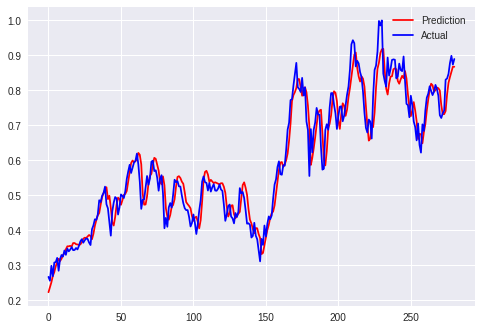

In [32]:
import matplotlib.pyplot as plt2

plt2.plot(newp,color='red', label='Prediction')
plt2.plot(newy_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()